# Motor RNNs

Base code borrowed from [Feulner & Clopath, 2021](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008621)

To do: look at different kinds of feedback from og code -- including feedback learning (feedback type 6)


## Setup

In [3]:
# import python packages
import os
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
from IPython import display
import copy

In [4]:
# @title Set the project path
proj_path = "proj_rnn/"
if not os.path.exists(proj_path):
  os.makedirs(proj_path)

# set the directories where the results will be saved
savedir = os.path.join(proj_path, 'data/fig2/')
if not os.path.exists(savedir):
  os.makedirs(savedir)

set the parameters

In [5]:
# @title set parameters
# TODO: create dictionary

seed_id = 286                 # random seed for this simulation
np.random.seed(seed_id)

# time parameters
dt = 0.01                   # time discretization (secs, see paper table 1)
T = 2                       # trial duration (secs, see paper table 1)
time = np.arange(0, T, dt)
tsteps = len(time)          # number of time steps within a trial
pulse_length = int(0.2/dt)  # pulse length in number of timesteps

# network parameters
N = 800                     # RNN number of units
g = 1.5                     # RNN recurrent connection strengths (a.u)
p = 0.1                     # RNN connection probability
tau = 0.07                   # unit time constant tau (secs)
N_OUTPUT_UNITS = 2          # number of output units (2 for x and y)

# task parameters
targets = 6                 # number of reaching targets
stimulus_type = 'constant'  # constant, linear, normal
target_max = 0.2            # 0.2 or 0.01
n_learning1_trials = 100       # initial network learning     CHANGED from 80
delta = 20.
relearning_trials = 50      # relearning         CHANGED from 80
deltarec = 20.
alphas = np.array([0.05, 0.1, 0.25, 0.5, 0.25, 0.75, 0.5, 0.85, 0.75, 1.])
alphas_control = np.array([0.05, 0.1, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 1.])
# alphas = np.array([0.2, 0.4, 0.6, 0.2, 0.8, 1.])
# alphas_control = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.])

# analyses parameters
manifold_trials = 50        # manifold calculation      CHANGED from 50
reduced_dim = 10

## Utils

### Network

In [6]:
# @title RNN encoder
class RNN(object):
    """
    Class implementing a recurrent network (not following Dale's law).

    Parameters:
    -----------
    * N: number of neurons
    * N_in: how many inputs can the network have
    * N_out: how many neurons are recorded by external device
    * g: recurrent coupling strength
    * p: connection probability
    * tau: neuron time constant
    * dt: set dt for simulation
    * delta: defines initial learning rate for FORCE
    * P_plastic: how many neurons are plastic in the recurrent network
    """
    def __init__(self, N=800, g=1.5, p=0.1, tau=0.1, dt=0.01,
                 N_in=6):
        # set parameters
        self.N = N
        self.g = g
        self.p = p
        self.K = int(p*N)
        self.tau = tau
        self.dt = dt

        # create recurrent W
        mask = np.random.rand(self.N,self.N)<self.p
        np.fill_diagonal(mask,np.zeros(self.N))
        self.mask = mask
        self.W = self.g / np.sqrt(self.K) * np.random.randn(self.N,self.N) * mask

        # create Win and Wout
        self._N_in = N_in
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    @property
    def N_in(self):
        return self._N_in

    @N_in.setter
    def N_in(self, value):
        self._N_in = value
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    def save(self,filename):
        np.savez(
            filename,
            N = self.N,
            K = self.K,
            tau = self.tau,
            g = self.g,
            p = self.p,
            dt = self.dt,
            W_in = self.W_in,
            W = self.W,
            N_in = self._N_in,
        )

    def load(self,filename):
        net = np.load(filename+'.npz')
        self.N = int(net['N'])
        self.dt = float(net['dt'])
        self.K = int(net['K'])
        self.tau = float(net['tau'])
        self.g = float(net['g'])
        self.p = float(net['p'])
        self.W_in = net['W_in']
        self.W = net['W']
        self._N_in = int(net['N_in'])

    def update_activation(self):
        self.z = np.tanh(self.r)

    def update_neurons(self,ext):
        self.r = self.r + self.dt/self.tau * \
             (-self.r + np.dot(self.W, self.z) + np.dot(self.W_in,ext))

        self.update_activation()

    def simulate(self, T, ext=None, r0=None):

        # define time
        time = np.arange(0,T,self.dt)
        tsteps = int(T/self.dt)

        # create input in case no input is given
        if ext is None:
            ext = np.zeros((tsteps,self.N_in))

        # check if input has the right shape
        if ext.shape[0]!=tsteps or ext.shape[1]!=self.N_in:
            print('ERROR: stimulus shape should be (time x number of input nodes)')
            return

        # set initial condition
        if r0 is None:
            self.r = (np.random.rand(self.N)-0.5)*2.
        else:
            self.r = r0
        self.update_activation()

        # start simulation
        record_r = np.zeros((tsteps,self.N))
        record_r[0,:] = self.r
        for i in range(1,tsteps):
            self.update_neurons(ext=ext[i])
            # store activity
            record_r[i,:] = self.r
        return time, record_r, np.tanh(record_r)

    def relearn(self, trials, ext, ntstart, decoder, feedback, target, delta=1.,
                wplastic=None):
        """
        Args
          self.z: RNN network's activation
          ext (np.array): stimuli (n_targets, n timesteps, n_targets)
          decoder (np.array): (N units, 2d coordinates) decoder weights
          feedback (np.array): (N units, 2d coordinates) feedback weights
          target: (n_targets, N timesteps, 2d coordinates) target coordinates

        Returns:

          loss (np.array): loss by trial
        """
        # get number of timesteps within trial
        tsteps = ext.shape[1]

        # set up learning
        if wplastic is None:
            self.W_plastic = [np.where(self.W[i,:]!=0)[0] for i in range(self.N)]
        else:
            self.W_plastic = wplastic
        self.P = [1./delta*np.eye(len(self.W_plastic[i])) for i in range(len(self.W_plastic))]

        # create n trials of target indices chosen from 0 to 5
        order = np.random.choice(range(ext.shape[0]), trials, replace=True)

        # initialize calculated loss per trial
        record_loss = np.zeros(trials)

        # loop over trials
        for t in range(trials):
            # initialize loss
            loss = 0.
            self.r = (np.random.rand(self.N)-0.5)*2.
            self.update_activation()

            # loop over time
            for i in range(1,tsteps):

                # update units
                self.update_neurons(ext=ext[order[t],i])

                # learn
                if i > ntstart and i%2==0:

                    # decode network's predicted
                    # target coordinates
                    c = decoder @ self.z

                    # calculate prediction error between
                    # decoded and true target coordinates (2,)
                    errc = c - target[order[t], i]
                    
                    # calculate the error update assigned to each weight
                    err1 = feedback @ errc

                    # calculate loss
                    loss += np.mean(err1**2)

                    # update plastic recurrent weights
                    for j in range(self.N):
                        z_plastic = self.z[self.W_plastic[j]]
                        pz = np.dot(self.P[j], z_plastic)
                        norm = (1. + np.dot(z_plastic.T,  pz))
                        self.P[j] -= np.outer(pz, pz)/norm

                        # use error-transformed feedbacks to update
                        # plastic weights
                        self.W[j, self.W_plastic[j]] -= err1[j] * pz / norm

            # tape loss
            record_loss[t] = loss
            print('Loss in Trial %d is %.5f'%(t+1,loss))
        return record_loss
    
    def test(self, trials, ext, ntstart, decoder, feedback, target, delta=1.,
                wplastic=None):
        """
        Args
          self.z: RNN network's activation
          ext (np.array): stimuli (n_targets, n timesteps, n_targets)
          decoder (np.array): (N units, 2d coordinates) decoder weights
          feedback (np.array): (N units, 2d coordinates) feedback weights
          target: (n_targets, N timesteps, 2d coordinates) target coordinates

        Returns:

          loss (np.array): loss by trial
        """
        # get number of timesteps within trial
        tsteps = ext.shape[1]

        # set up learning
        if wplastic is None:
            self.W_plastic = [np.where(self.W[i,:]!=0)[0] for i in range(self.N)]
        else:
            self.W_plastic = wplastic
        self.P = [1./delta*np.eye(len(self.W_plastic[i])) for i in range(len(self.W_plastic))]

        # create n trials of target indices chosen from 0 to 5
        order = np.random.choice(range(ext.shape[0]), trials, replace=True)

        # initialize calculated loss per trial
        record_loss = np.zeros(trials)

        # loop over trials
        for t in range(trials):
            # initialize loss
            loss = 0.
            self.r = (np.random.rand(self.N)-0.5)*2.
            self.update_activation()

            # loop over time
            for i in range(1,tsteps):

                # update units
                self.update_neurons(ext=ext[order[t],i])

                # learn
                if i > ntstart and i%2==0:

                    # decode network's predicted
                    # target coordinates
                    c = decoder @ self.z

                    # calculate prediction error between
                    # decoded and true target coordinates (2,)
                    errc = c - target[order[t], i]
                    
                    # calculate the error update assigned to each weight
                    err1 = feedback @ errc

                    # calculate loss
                    loss += np.mean(err1**2)

            # tape loss
            record_loss[t] = loss
        return record_loss
    

    def calculate_manifold(self, trials, ext, ntstart):
        tsteps = ext.shape[1]
        T = self.dt*tsteps
        points = (tsteps-ntstart)
        activity = np.zeros((points*trials,self.N))
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)
        for t in range(trials):
            time, r, z = self.simulate(T,ext[order[t]])
            activity[t*points:(t+1)*points,:] = z[ntstart:,:]
        cov = np.cov(activity.T)
        ev,evec = np.linalg.eig(cov)
        pr = np.round(np.sum(ev.real)**2/np.sum(ev.real**2)).astype(int)
        xi = activity @ evec.real
        return activity,cov,ev.real,evec.real,pr,xi,order

def save_RNN(network, savedir:str):
  """write RNN object and weights in savedir
  """
  network.save(savedir+'network')
  np.save(savedir+'W_initial', network.W)

def save_RNN_sinewave(network, savedir:str):
  """write RNN sinewave object and weights in savedir
  """
  network.save(savedir + 'network_sinewave')
  np.save(savedir + 'W_initial_sinewave', network.W)

In [7]:
# @title BCI decoders
def train_reaching_decoder(inputP, target, order, n_output_units:int=2):
    """train the decoder to perform the six-cue
    motor reaching task
    """
    # initialize predictor neural activity
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))

    # initialize predicted target
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], n_output_units))

    # fill up
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]

    # regress target against neural activity
    reg = lm.LinearRegression()
    reg.fit(X,Y)

    # make predictions
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
    return reg.coef_, mse

def create_reaching_task_decoder(reaching_network, n_output_units:int=2):
  """create feedforward decoder from RNN to (x,y) output units
  for learning (random weights)"""

  # set parameters
  SCALE = 0.04
  DENOM = 0.2

  # create random weights
  reaching_decoder = np.random.randn(n_output_units, reaching_network.N)
  initial_decoder_fac = SCALE * (target_max / DENOM)

  # normalize decoder matrix
  reaching_decoder *= (initial_decoder_fac / np.linalg.norm(reaching_decoder))
  return reaching_decoder

def train_force_exertion_decoder(inputP, target, order, n_output:int=1):
    """train the decoder to perform the force exertion
    motor task. The network must apply force at
    oscillating amplitude (following a sinewave function
    of time)
    """

    # initialize predictor neural activity
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))

    # initialize predicted target
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], n_output))

    # fill up
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]

    # regress target against neural activity
    reg = lm.LinearRegression()
    reg.fit(X, Y)

    # make predictions
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
    return reg.coef_, mse

In [8]:
# @title Feedback weights
def get_feedback_weights(decoder):
  """calculate feedback weights from (x,y) output units back to RNN
  as the matrix inverse of the feedforward decoder weights from the RNN to
  the output units"""
  return np.linalg.pinv(decoder)

In [9]:
# @title Loss function
def get_cost(result, target, order):
  cost = 0
  for j in range(result.shape[0]):
    error = result[j, :, :] - target[order[j], :, :]
    cost += np.mean(error**2)
  return cost

def select_random_perturbations(activity2,D,P):    
    runs = 5 # number of random seeds  #CHANGED FROM 200
    cost = np.zeros((runs,2))
    for j in range(runs):
        # set random seed for reproduction
        np.random.seed(j)
        # within-manifold perturbation
        perm_matrix_within = np.eye(reduced_dim)
        np.random.shuffle(perm_matrix_within)
        D_permute = D.copy()
        D_permute[:reduced_dim,:reduced_dim] = D[:reduced_dim,:reduced_dim] @ perm_matrix_within
        T_within = D_permute @ P
        result_within = activity2 @ T_within.T
        cost[j,0] = get_cost(result_within,target[:,pulse_length:,:],order)
        # set random seed for reproduction
        np.random.seed(j)
        # outside-manifold perturbation
        perm_matrix_outside = np.eye(network.N)
        np.random.shuffle(perm_matrix_outside)
        P_permute = P @ perm_matrix_outside
        T_outside = D @ P_permute
        result_outside = activity2 @ T_outside.T
        cost[j,1] = get_cost(result_outside,target[:,pulse_length:,:],order)
    # select closest to 1 perturbations
    dif = abs(cost-np.mean(cost))
    idx = np.argsort(dif,axis=0)
    return idx # first column seeds for within, second column seeds for outside

In [10]:
# @title Get the manifold
def get_manifold(network):

  # calculate the manifold
  activity, cov, ev, evec, pr, xi, order = network.calculate_manifold(trials=manifold_trials, ext=stimulus, ntstart=pulse_length)

  # reshape the activity
  activity_reshaped = activity.reshape(manifold_trials, -1, network.N)
  xi2 = xi.reshape(manifold_trials, -1, network.N)
  return {"xi2":xi2, "order":order, "xi":xi, "cov":cov, "ev":ev, "evec":evec, "pr":pr,"activity":activity, "activity_reshaped":activity_reshaped}

def save_reaching_manifold(data, T):
  dic = {'manifold': {'original': data['manifold']}, 'perturbations': {'transformed':T}}
  np.save(savedir + 'reaching_relearning_results', dic)

def transform_reaching(reaching_network, manifold_out, W_bci4, n_output_units:int=2):

  P = manifold_out["evec"].real.T
  D = np.zeros((2, reaching_network.N))
  D[:,:reduced_dim] = W_bci4
  transformed = D @ P
  result = manifold_out["activity_reshaped"] @ transformed.T
  cost = get_cost(result, target[:,pulse_length:,:], manifold_out["order"])
  return transformed

In [11]:
# @title simulation
def simulate_reaching(savdir, dt):

  # set plot parameters
  COL_ORIG = 'k'
  ALPHA = 1

  # load velocity data
  data = np.load(savdir + 'reaching_relearning_results.npy', allow_pickle=True).item()
  activity = data['manifold']['original']['activity2']
  o_original = activity @ data['perturbations']['transformed'].T

  # reconstruct trajectories from velocities
  pos_original = np.zeros(o_original.shape)
  for j in range(activity.shape[1]):
      pos_original[:,j,:] = pos_original[:,j-1,:] + o_original[:,j,:]*dt

  # plot trajectories
  plt.figure(figsize=(15,10), dpi=96)
  plt.subplot(2,3,3)
  for j in range(manifold_trials):
      plt.plot(pos_original[j,:,0], pos_original[j,:,1], COL_ORIG, alpha=ALPHA);
  plt.title('simulated reaching');
  plt.xlabel('x-position on screen');
  plt.ylabel('y-position on screen');

### Task

In [12]:
# @title "reaching" task
def create_reaching_task_stimuli(tsteps:int, pulse_steps:int, n_targets:int=6, amplitude:float=1., twod:bool=False):
    """create the set of stimuli, which we sample from at each trial

    Args:
      tsteps (int):
      pulse_steps (int):
      n_targets (int):
      amplitude (float):
      twod (bool):

    Returns:
      (np.array): array of (n_targets, pulse_steps, n_targets) stimuli
    """

    # create stimulus
    stimulus = np.zeros((n_targets, tsteps, n_targets))
    if twod:
        phis = np.linspace(0,2*np.pi,targets,endpoint=False)
        for j in range(stimulus.shape[0]):
            stimulus[j,:pulse_length,0] = amplitude*np.cos(phis[j])
            stimulus[j,:pulse_length,1] = amplitude*np.sin(phis[j])
            stimulus[j,:pulse_length,2:] = 0
    else:
        for j in range(n_targets):
            stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def create_reaching_task_targets(tsteps, pulse_steps, n_targets:int=6, stype='constant', target_max:float=0.2):
    """create the set of target coordinates (6 by default) that the network
    must reach before the end of a trial. The network starts from the center of
    the computer screen (coordinate: (0,0))
    """
    # create target trajectories
    phis = np.linspace(0, 2*np.pi, n_targets, endpoint=False)
    rs = np.zeros(tsteps)

    # define each target's x and y coordinate
    rs[pulse_steps:] = np.ones(tsteps-pulse_steps)*target_max
    traj = np.zeros((n_targets,tsteps,2))
    for j in range(n_targets):

        # create x-coordinate on screen
        traj[j,:,0] = rs*np.cos(phis[j])

        # create y-coordinate on screen
        traj[j,:,1] = rs*np.sin(phis[j])
    return traj

def plot_reaching_task_stimuli(stimulus, n_targets:int, tsteps:int, T:int):

  # plot target cue with "pulse_steps" duration
  # at the beginnning of each trial
  stimulus_set = np.arange(0, n_targets,1)

  fig, axes = plt.subplots(n_targets, 1, figsize=(30,9))

  for target in stimulus_set:
    axes[target].imshow(stimulus[target,:,:].T, aspect=10, cmap="binary");

    # legend
    axes[target].set_yticks(stimulus_set)
    axes[target].set_yticklabels(stimulus_set, fontsize=9)
    axes[target].set_xticks([0, tsteps])
    axes[target].set_xticklabels([0, T])
    axes[target].set_ylabel("possible targets", fontsize=9)

  axes[-1].set_xlabel("time within a trial (secs)")

  fig.tight_layout()

  print("stimuli:")
  print(f"-a set of {stimulus.shape[0]} possible trial stimuli (panels)")
  print(f"-{stimulus.shape[1]} timesteps within a trial stimulus")
  print(f"-{stimulus.shape[2]} possible cued target in a trial stimulus")

def plot_reaching_task_targets(target, tsteps:int, T:int):

  # count targets
  n_targets = target.shape[0]

  # plot target coordinates throughout trial
  fig, axes = plt.subplots(n_targets,1, figsize=(6,6))
  for target_i in tuple(range(n_targets)):
    axes[target_i].plot(target[target_i,:,:])

    # legend
    axes[target_i].set_xticks([0, tsteps])
    axes[target_i].set_xticklabels([0, T])
    axes[target_i].set_ylabel("target" "\n" "coord (a.u.)", fontsize=9)
    axes[target_i].set_ylim([target.min()-0.01, target.max()+0.01])

  axes[-1].set_xlabel("time within a trial (secs)")
  plt.legend(["x-coord", "y-coord"], fontsize=9, frameon=False)
  fig.tight_layout()

In [13]:
# @title "force" task
def create_force_task_stimuli(tsteps:int, pulse_steps:int, n_targets:int=1, amplitude:float=1., twod:bool=False):
    """create a stimulus set

    Args:
      tsteps (int):
      pulse_steps (int):
      n_targets (int):
      amplitude (float)
      twod (bool):

    Returns:
      (np.array): array of (n_targets, pulse_steps, n_targets) stimuli
    """

    # create stimuli
    stimulus = np.zeros((n_targets, tsteps, n_targets))
    for j in range(n_targets):
        stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def plot_force_stimuli(stimulus, n_targets:int, tsteps:int, T:int):

  # plot target cue with "pulse_steps" duration
  # at the beginnning of each trial
  stimulus_set = np.arange(0, n_targets, 1)
  fig, axes = plt.subplots(n_targets, 1, figsize=(30,9))
  for target in stimulus_set:

    # plot
    axes[target].imshow(stimulus[target,:,:].T, aspect=10, cmap="binary");

    # legend
    axes[target].set_yticks(stimulus_set)
    axes[target].set_yticklabels(stimulus_set, fontsize=9)
    axes[target].set_xticks([0, tsteps])
    axes[target].set_xticklabels([0, T])
    axes[target].set_ylabel("possible targets", fontsize=9)
  axes[-1].set_xlabel("time within a trial (secs)")
  fig.tight_layout()
  print("stimuli:")
  print(f"-a set of {stimulus.shape[0]} possible trial stimuli (panels)")
  print(f"-{stimulus.shape[1]} timesteps within a trial stimulus")
  print(f"-{stimulus.shape[2]} possible cued target in a trial stimulus")

def create_force_task_targets(tsteps, pulse_steps, targets:list=[1, 10], target_max:float=0.2):
  """exert force with an oscillatorily increasing and decreasing amplitude
  """
  n_targets = len(targets)
  rs = np.zeros(tsteps)
  traj = np.zeros((n_targets, tsteps, 1))
  rs[pulse_steps:] = np.ones(tsteps - pulse_steps) * target_max
  x_coord = np.linspace(-2*np.pi, 2*np.pi, tsteps, endpoint=False)
  freq = []
  for ix in range(n_targets):
    traj[ix,:,0] = rs * np.sin(targets[ix] * x_coord)
  return traj

def plot_force_task_targets(target, tsteps:int, T:int):

  # count targets
  n_targets = target.shape[0]

  # plot target coordinates throughout trial
  fig, axes = plt.subplots(n_targets,1, figsize=(6,6));
  for target_i in tuple(range(n_targets)):

    # plot
    axes[target_i].plot(target[target_i,:,:]);

    # legend
    axes[target_i].set_xticks([0, tsteps]);
    axes[target_i].set_xticklabels([0, T]);
    axes[target_i].set_ylabel("target" "\n" "coord (a.u.)", fontsize=9);
    axes[target_i].set_ylim([target.min()-0.01, target.max()+0.01]);
  axes[-1].set_xlabel("time within a trial (secs)");
  plt.legend(["x-coord", "y-coord"], fontsize=9, frameon=False);
  fig.tight_layout();

## Create 

## Create task 1: "reaching"

stimuli:
-a set of 6 possible trial stimuli (panels)
-200 timesteps within a trial stimulus
-6 possible cued target in a trial stimulus


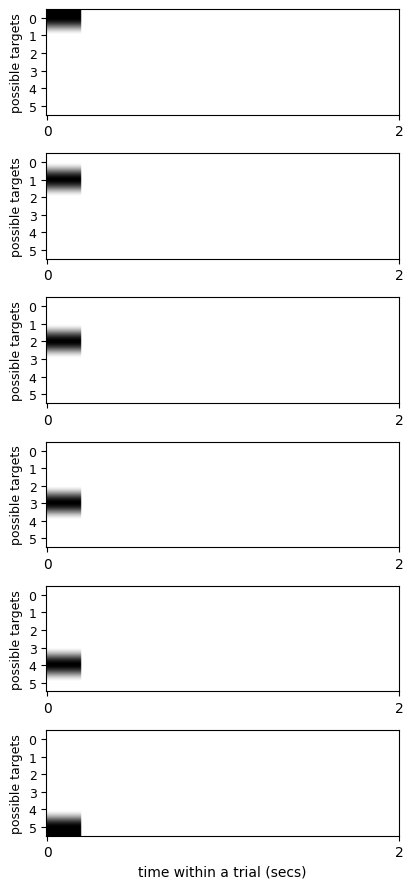

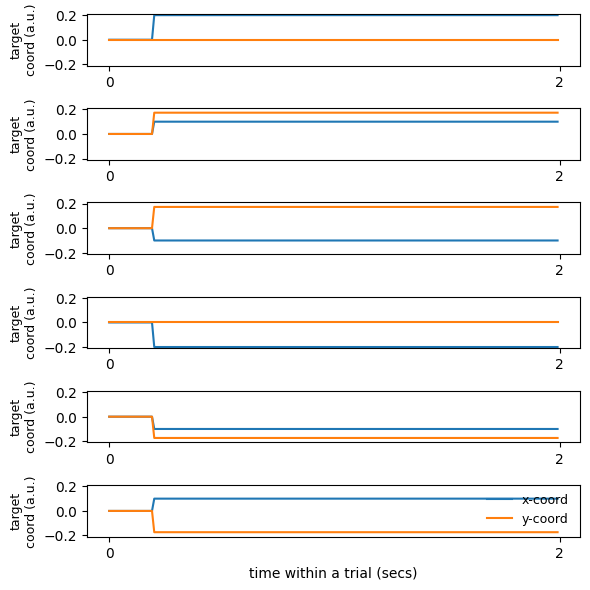

In [14]:
# @title Create stimuli and targets

# create stimuli and plot
stimulus = create_reaching_task_stimuli(tsteps, pulse_length, twod=False)
plot_reaching_task_stimuli(stimulus, targets, tsteps, T)

# create target (targets x timesteps x 2D coordinates) and plot
target = create_reaching_task_targets(
    tsteps,
    pulse_length,
    n_targets=targets,
    stype=stimulus_type,
    target_max=target_max
    )
plot_reaching_task_targets(target, tsteps, T)

In [15]:
# @title build and train the network
# create and save RNN encoder
reaching_network = RNN(N=N, g=g, p=p, tau=tau, dt=dt, N_in=targets)
save_RNN(reaching_network, savedir)

# create feedforward decoder from RNN to (x,y) output units
reaching_decoder = create_reaching_task_decoder(reaching_network,
                                                n_output_units=N_OUTPUT_UNITS)

# create feedback weights from (x,y) output units back to RNN
reaching_feedback = get_feedback_weights(reaching_decoder)

# train and save the RNN encoder weights (learn the task)
reaching_loss = reaching_network.relearn(n_learning1_trials, stimulus,
                                         pulse_length, reaching_decoder,
                                         reaching_feedback, target, delta=delta)
np.save(f'{savedir}W_stabilized_reaching', reaching_network.W)
w1_reaching = reaching_network.W.copy()

# get the RNN's manifold
manifold_out = get_manifold(reaching_network)

# train the decoder
W_bci4, l4 = train_reaching_decoder(manifold_out["xi2"][:, :, :reduced_dim],
                                    target[:, pulse_length:, :],
                                    manifold_out["order"],
                                    n_output_units=N_OUTPUT_UNITS)

# transform
transformed = transform_reaching(reaching_network, manifold_out,
                                 W_bci4, n_output_units=N_OUTPUT_UNITS)

manifold = {'original':{'activity':manifold_out["activity"],
                'activity2':manifold_out["activity_reshaped"],
                'xi':manifold_out["xi"],
                'xi2':manifold_out["xi2"],
                'cov':manifold_out["cov"],'ev':manifold_out["ev"],'evec':manifold_out["evec"],'pr':manifold_out["pr"],'order':manifold_out["order"]}}

Loss in Trial 1 is 0.31414
Loss in Trial 2 is 0.44998
Loss in Trial 3 is 0.42650
Loss in Trial 4 is 0.05898
Loss in Trial 5 is 0.32809
Loss in Trial 6 is 0.08149
Loss in Trial 7 is 0.15321
Loss in Trial 8 is 0.05598
Loss in Trial 9 is 0.12351
Loss in Trial 10 is 0.06808
Loss in Trial 11 is 0.35637
Loss in Trial 12 is 0.04074
Loss in Trial 13 is 0.11469
Loss in Trial 14 is 0.10145
Loss in Trial 15 is 0.09989
Loss in Trial 16 is 0.05081
Loss in Trial 17 is 0.07001
Loss in Trial 18 is 0.13536
Loss in Trial 19 is 0.15058
Loss in Trial 20 is 0.09001
Loss in Trial 21 is 0.03453
Loss in Trial 22 is 0.17262
Loss in Trial 23 is 0.32072
Loss in Trial 24 is 0.08576
Loss in Trial 25 is 0.03381
Loss in Trial 26 is 0.04686
Loss in Trial 27 is 0.06813
Loss in Trial 28 is 0.07049
Loss in Trial 29 is 0.14657
Loss in Trial 30 is 0.04298
Loss in Trial 31 is 0.17474
Loss in Trial 32 is 0.02234
Loss in Trial 33 is 0.38601
Loss in Trial 34 is 0.04209
Loss in Trial 35 is 0.13290
Loss in Trial 36 is 0.02503
L

In [16]:
# @title Save run data
# format and save data for this run
run_data = {
    'params':{
        'dt':dt,
        'T':T,
        'time':time,
        'tsteps':tsteps,
        'pulse_length':pulse_length,
        'manifold_trials':manifold_trials,
        'target_max':target_max,
        'stimulus_type':stimulus_type,
        'N':N,
        'tau':tau,
        'g':g,
        'p':p
        },
    'stimulus':stimulus,
    'target':target,
    'stabilizing':{
        'learning_trials':n_learning1_trials,
        'delta':delta,
        'decoder':reaching_decoder,
        'feedback':reaching_feedback,
        'stabilize_loss':reaching_loss
        },
    'manifold':{
        'activity':manifold_out["activity"],
        'activity2':manifold_out["activity_reshaped"],
        'xi':manifold_out["xi"],
        'xi2':manifold_out["xi2"],
        'cov':manifold_out["cov"],
        'ev':manifold_out["ev"],
        'evec':manifold_out["evec"],
        'pr':manifold_out["pr"],
        'order': manifold_out["order"]
        },
    'decoding':{
        'reduced_dim': reduced_dim,
        'weights': W_bci4,
        'loss':l4
        }
        }
np.save(f'{savedir}reaching_experiment_results', run_data)

# save manifold data separately
save_reaching_manifold(run_data, transformed)

### simulate reaching

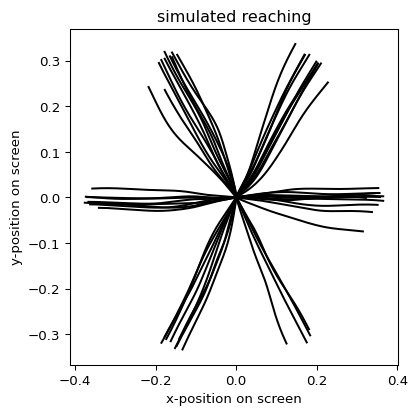

In [17]:
# simulate reaching
trajectories = simulate_reaching(savedir, dt)

## Add perturbations 

In [18]:
# original transformation
evec = manifold_out["evec"]
activity2 = manifold_out["activity_reshaped"]
order = manifold_out["order"]
network = copy.deepcopy(reaching_network)
w1 = w1_reaching


P = evec.real.T
D = np.zeros((2,network.N))
D[:,:reduced_dim] = W_bci4
T = D @ P
result_original = activity2 @ T.T
cost_original = get_cost(result_original,target[:,pulse_length:,:],order)
  
# select equal perturbation result shuffling seeds
idx_shuffling_seeds = select_random_perturbations(activity2,D,P) # within, outside
within_seed = idx_shuffling_seeds[0,0] # 79
outside_seed = idx_shuffling_seeds[0,1] # 189

# within-manifold perturbation
np.random.seed(within_seed)
perm_matrix_within = np.eye(reduced_dim)
np.random.shuffle(perm_matrix_within)
D_permute = D.copy()
D_permute[:reduced_dim,:reduced_dim] = D[:reduced_dim,:reduced_dim] @ perm_matrix_within
T_within = D_permute @ P
result_within = activity2 @ T_within.T
cost_within = get_cost(result_within,target[:,pulse_length:,:],order)

# outside-manifold perturbation
np.random.seed(outside_seed)
perm_matrix_outside = np.eye(network.N)
np.random.shuffle(perm_matrix_outside)
P_permute = P @ perm_matrix_outside
T_outside = D @ P_permute
result_outside = activity2 @ T_outside.T
cost_outside = get_cost(result_outside,target[:,pulse_length:,:],order)


4## Implement interleaved replay   

In [19]:
# modified from incremental learning. goal is instead of linearly increasing alpha, 
# we periodically give a lower alpha than the current one. then we run a version of 
# incremental learning to compare as control. here len(alpha_controls) is the same as len(alpha),
# so any performance differences are due to replay, not the granularity of the increment

# # run the interleaved eplay
w_outside = [np.copy(w1)]


print("now running interleaved")
for j in range(len(alphas)):
    print('Run %d'%(j+1))
    print("alpha: ")
    print(alphas[j])
    # set incremental BCI
    Tinc = (1-alphas[j])*T + (alphas[j])*T_outside
    Pinc = np.linalg.pinv(D) @ Tinc
    # RETRAIN
    network.W = w_outside[j] # start from initial training setup
    fb_outside = np.linalg.pinv(Tinc) # take correct feedback for retraining
    # recurrent relearning
    loss_outside = network.relearn(relearning_trials, stimulus, pulse_length, 
                      Tinc, fb_outside, target, delta=deltarec)
    w_outside.append(np.copy(network.W))


now running interleaved
Run 1
alpha: 
0.05
Loss in Trial 1 is 0.25910
Loss in Trial 2 is 0.52314
Loss in Trial 3 is 0.36946
Loss in Trial 4 is 0.11492
Loss in Trial 5 is 0.10224
Loss in Trial 6 is 0.96150
Loss in Trial 7 is 0.08831
Loss in Trial 8 is 0.49716
Loss in Trial 9 is 0.22909
Loss in Trial 10 is 0.19854
Loss in Trial 11 is 0.46372
Loss in Trial 12 is 0.95766
Loss in Trial 13 is 0.06057
Loss in Trial 14 is 0.09791
Loss in Trial 15 is 0.23898
Loss in Trial 16 is 0.22329
Loss in Trial 17 is 1.15522
Loss in Trial 18 is 0.08217
Loss in Trial 19 is 0.42947
Loss in Trial 20 is 0.10805
Loss in Trial 21 is 0.72183
Loss in Trial 22 is 0.06300
Loss in Trial 23 is 0.19521
Loss in Trial 24 is 0.29361
Loss in Trial 25 is 0.41217
Loss in Trial 26 is 0.19134
Loss in Trial 27 is 0.26735
Loss in Trial 28 is 0.20841
Loss in Trial 29 is 0.05594
Loss in Trial 30 is 0.24030
Loss in Trial 31 is 0.04838
Loss in Trial 32 is 0.27852
Loss in Trial 33 is 0.16372
Loss in Trial 34 is 0.35111
Loss in Trial 

In [20]:
network_control = copy.deepcopy(reaching_network)
w_outside_control = []

print("now running control")
# now run the control
for j in range(len(alphas_control)):
    print('Run %d'%(j+1))
    print("alpha_control: ")
    print(alphas_control[j])
    # set incremental BCI
    Tinc = (1-alphas_control[j])*T + (alphas_control[j])*T_outside
    Pinc = np.linalg.pinv(D) @ Tinc
    # RETRAIN
    network_control.W = np.copy(w1) # start from initial training setup
    fb_outside_control = np.linalg.pinv(Tinc) # take correct feedback for retraining
    # recurrent relearning
    loss_outside = network_control.relearn(relearning_trials, stimulus, pulse_length, 
                      Tinc, fb_outside_control, target, delta=deltarec)
    w_outside_control.append(np.copy(network_control.W))
   

now running control
Run 1
alpha_control: 
0.05
Loss in Trial 1 is 0.21376
Loss in Trial 2 is 0.13530
Loss in Trial 3 is 0.19273
Loss in Trial 4 is 0.61109
Loss in Trial 5 is 1.07195
Loss in Trial 6 is 0.34779
Loss in Trial 7 is 0.12148
Loss in Trial 8 is 0.15720
Loss in Trial 9 is 0.12805
Loss in Trial 10 is 0.46336
Loss in Trial 11 is 0.27613
Loss in Trial 12 is 0.11399
Loss in Trial 13 is 0.15730
Loss in Trial 14 is 0.17429
Loss in Trial 15 is 0.15966
Loss in Trial 16 is 0.65347
Loss in Trial 17 is 0.15940
Loss in Trial 18 is 0.53155
Loss in Trial 19 is 0.17911
Loss in Trial 20 is 0.15821
Loss in Trial 21 is 0.13698
Loss in Trial 22 is 0.11691
Loss in Trial 23 is 0.17363
Loss in Trial 24 is 0.12741
Loss in Trial 25 is 0.37846
Loss in Trial 26 is 0.30295
Loss in Trial 27 is 0.25375
Loss in Trial 28 is 0.26220
Loss in Trial 29 is 0.14363
Loss in Trial 30 is 0.09496
Loss in Trial 31 is 0.25851
Loss in Trial 32 is 0.18295
Loss in Trial 33 is 0.25804
Loss in Trial 34 is 0.12949
Loss in Tr

test on different alphas


In [32]:
talphas = [1.,0.,0.3,0.6,0.9,-.3,-.7]
def test_rnn(rnn, target, stimulus):
  
    # simulate new activiy data 
    activityt,cov,ev,evec,pr,xi,order = rnn.calculate_manifold(trials=manifold_trials, 
                                                                  ext=stimulus, ntstart=pulse_length)
    activity2t = activityt.reshape(manifold_trials,-1,rnn.N)

    # decode the activity using a bunch of alpha values, some werent used in re-training, others are just weird
    output = []
    for a in talphas:
        test_T = (1-a)*T + (a)*T_outside
        result = activity2t @ test_T.T
        output.append(get_cost(result,target[:,pulse_length:,:],order))
    return output
test_seeds = [123,54,675,2245,98,34,76564,8734,12931,90423]

interleaved_results = []
incremental_results = []
for seed in test_seeds:
    np.random.seed(seed)
    print(seed)
    interleaved_result = test_rnn(network, target, stimulus)
    incremental_result = test_rnn(network_control, target, stimulus)

    for i, a in enumerate(talphas):
        print("mse interleaved          alpha: ", a, "          mse: ", interleaved_result[i])
        print("mse incremental          alpha: ", a, "          mse: ", incremental_result[i])

    interleaved_results.append(interleaved_result)
    incremental_results.append(incremental_result)
    


123
mse interleaved          alpha:  1.0           mse:  0.048062767066911885
mse incremental          alpha:  1.0           mse:  0.006673431983068375
mse interleaved          alpha:  0.0           mse:  0.08483436744121088
mse incremental          alpha:  0.0           mse:  1.3062039688672136
mse interleaved          alpha:  0.3           mse:  0.06502754484522465
mse incremental          alpha:  0.3           mse:  0.6463034480317943
mse interleaved          alpha:  0.6           mse:  0.05274244437812113
mse incremental          alpha:  0.6           mse:  0.21786694985652572
mse interleaved          alpha:  0.9           mse:  0.0479790660399004
mse incremental          alpha:  0.9           mse:  0.0208944743414076
mse interleaved          alpha:  -0.3           mse:  0.11216291216607992
mse incremental          alpha:  -0.3           mse:  2.1975685123627833
mse interleaved          alpha:  -0.7           mse:  0.16030142844416737
mse incremental          alpha:  -0.7          

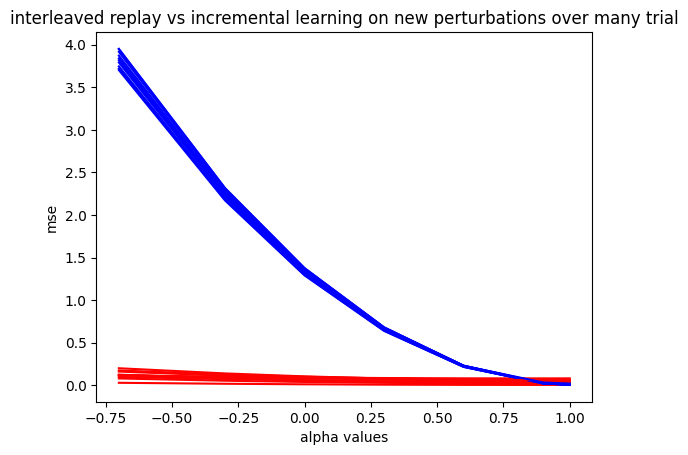

In [37]:
interleaved_results_ = np.array(interleaved_results)
incremental_results_ = np.array(incremental_results)

sorted_interleaved_results_ = np.vstack((interleaved_results_, talphas))
sorted_incremental_results_ = np.vstack((incremental_results_, talphas))

sorted_interleaved_results_ = sorted_interleaved_results_[:, sorted_interleaved_results_[-1,:].argsort()]
sorted_incremental_results_ = sorted_incremental_results_[:,sorted_incremental_results_[-1,:].argsort()]

# print(sorted_interleaved_results_)
for i in range(len(test_seeds)):
    # print(sorted_interleaved_results_[i])
    plt.plot(sorted_interleaved_results_[-1], sorted_interleaved_results_[i], 'r')
    plt.plot(sorted_incremental_results_[-1], sorted_incremental_results_[i], 'b')

plt.xlabel("alpha values")
plt.ylabel("mse")
plt.title("interleaved replay vs incremental learning on new perturbations over many trial")
plt.show()

## Create task 2: "force"

Don't hesitate to use some of the utils functions that have been implemented for this tasks under the "force" task section.

Can you think of other tasks to test?